In [ ]:
!pip install numpy==1.24

In [ ]:
from process_data_new import process_data
V_data, CDR3_data, J_data,tgt_data = process_data()

In [ ]:
print(tgt_data[0])

In [ ]:
print(V_data[0])
print(CDR3_data[0])
print(J_data[0])

In [ ]:
tgt_data[0] ==  V_data[0]+ " " + CDR3_data[0] + " " +  J_data[0] 

In [ ]:
import pickle 

In [ ]:
train_set = (V_data, CDR3_data, J_data,tgt_data)
with open('train_set_.pkl', 'wb') as f:
    pickle.dump(train_set, f)
f.close()

In [1]:
import torch
import torch.nn as nn
import numpy as np
from transformers import BertModel, AutoTokenizer, BertConfig
import matplotlib.pyplot as plt
import pickle 

In [2]:
torch.set_default_dtype(torch.float64)

In [3]:
with open('train_set_.pkl', 'rb') as f:
    V_data, CDR3_data, J_data, tgt_data = pickle.load(f)
f.close()

In [4]:
base_model = BertModel.from_pretrained('Rostlab/prot_bert_bfd')
tokenizer = AutoTokenizer.from_pretrained('Rostlab/prot_bert_bfd', add_special_tokens=False)
config = BertConfig.from_pretrained('Rostlab/prot_bert_bfd')

In [5]:
print(config)

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.0,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 40000,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 30,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.31.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30
}



In [6]:
print(base_model)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30, 1024, padding_idx=0)
    (position_embeddings): Embedding(40000, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-29): 30 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.0, inpla

In [7]:
for i in base_model.encoder.layer[0].attention.self.parameters():
    print(i.shape)
    break

torch.Size([1024, 1024])


# Copy weights to own model

https://stackoverflow.com/questions/70814490/uploading-models-with-custom-forward-functions-to-the-huggingface-model-hub

https://stackoverflow.com/questions/67689219/copy-one-layers-weights-from-one-huggingface-bert-model-to-another

https://github.com/huggingface/transformers/blob/main/src/transformers/models/bert/modeling_bert.py

https://discuss.pytorch.org/t/copy-weights-from-only-one-layer-of-one-model-to-another-model-with-different-structure/153419

In [8]:
import transformers 
import torch.nn as nn

class CustomprotBERT(transformers.PreTrainedModel):
    def __init__(self, protBERT, CDR3_max_length):
        super(CustomprotBERT, self).__init__(config=BertConfig.from_pretrained('Rostlab/prot_bert_bfd'))
        
        self.config = protBERT.config
        self.CDR3_max_length = CDR3_max_length
        self.embeddings = protBERT.embeddings
        self.encoder= nn.TransformerEncoder(encoder_layer= nn.TransformerEncoderLayer(  d_model=self.config.hidden_size,
                                                                                        nhead=self.config.num_attention_heads,
                                                                                        dim_feedforward=self.config.intermediate_size,
                                                                                        dropout=self.config.hidden_dropout_prob,
                                                                                        activation=self.config.hidden_act,
                                                                                        layer_norm_eps=self.config.layer_norm_eps,
                                                                                        batch_first=True),
                                          num_layers = self.config.num_hidden_layers)
        self.fc = nn.Linear(config.hidden_size, self.config.vocab_size)

        self.initialize_weights(protBERT)

    def forward(self, v, cdr3, j, pad_mask=None,  mask=None):
        
        src_list = [torch.cat((t1,t2, t3), dim=-1) for t1, t2, t3 in zip(v, cdr3, j)]
        src = torch.stack(src_list)
        
        embed = self.embeddings(src)
        hidden_state = self.encoder(src=embed,
                                    mask=mask,
                                    src_key_padding_mask =pad_mask)
        
        v_idx = [i.shape[-1] -1 for i in v] # Indeces of the last value of the v gene
        cdr3_idx = [i + self.CDR3_max_length for i in v_idx] # Indeces of the last residue of the CDR3
        
        cdr3_hidden_state = torch.zeros((hidden_state.shape[0], self.CDR3_max_length, hidden_state.shape[-1]))
        
        for i in range(hidden_state.shape[0]):
            #print(hidden_state[i, v_idx[i]:cdr3_idx[i],:].shape)
            cdr3_hidden_state[i,:,:] = hidden_state[i, v_idx[i]:cdr3_idx[i],:] #1024 dim presentation of [V_v, CDR_1, ..., CDR_{N-1}]
        
        cdr3_logits = self.fc(cdr3_hidden_state)
        
        return cdr3_logits   
    '''   
    def forward(self,src, v=None, cdr3=None, j=None,pad_mask=None, mask=None):

        embed = self.embeddings(src)
        result = self.encoder(src=embed,
                              mask=mask,
                              src_key_padding_mask =pad_mask)
        
        cdr_hidden = torch.zeros((result.shape[0], self.CDR3_max_length, result.shape[-1]))
        for i, V in enumerate(v):
            
            cdr_hidden[i,:,:] = result[i,len(V):len(V)+self.CDR3_max_length, :]
            
        result = self.fc(cdr_hidden)
        return result    
    '''    
    
    def initialize_weights(self, protBERT):

            #this implementation works so that theresulting tensor is same as using 
            #Huggingface's model on the fourth decimal. Tensors are same in fifth decimal over 99.99%

            protBERT_encoder_weights = protBERT.encoder.state_dict()
            with torch.no_grad():
                for i in range(30):
                    weights = {
                        'att_weight': torch.cat((protBERT_encoder_weights[f'layer.{i}.attention.self.query.weight'],
                                                    protBERT_encoder_weights[f'layer.{i}.attention.self.key.weight'],
                                                    protBERT_encoder_weights[f'layer.{i}.attention.self.value.weight']),
                                                    axis=0),
                        'att_bias': torch.cat((protBERT_encoder_weights[f'layer.{i}.attention.self.query.bias'],
                                                    protBERT_encoder_weights[f'layer.{i}.attention.self.key.bias'],
                                                    protBERT_encoder_weights[f'layer.{i}.attention.self.value.bias']),
                                                    axis=0),
                        'att_out_weight': protBERT_encoder_weights[f'layer.{i}.attention.output.dense.weight'],
                        'att_out_bias': protBERT_encoder_weights[f'layer.{i}.attention.output.dense.bias'],
                        'interm_weight': protBERT_encoder_weights[f'layer.{i}.intermediate.dense.weight'],
                        'interm_bias': protBERT_encoder_weights[f'layer.{i}.intermediate.dense.bias'],
                        'out_weight': protBERT_encoder_weights[f'layer.{i}.output.dense.weight'],
                        'out_bias': protBERT_encoder_weights[f'layer.{i}.output.dense.bias'],
                        'norm1_weight': protBERT_encoder_weights[f'layer.{i}.attention.output.LayerNorm.weight'],
                        'norm1_bias': protBERT_encoder_weights[f'layer.{i}.attention.output.LayerNorm.bias'],
                        'norm2_weight': protBERT_encoder_weights[f'layer.{i}.output.LayerNorm.weight'],
                        'norm2_bias': protBERT_encoder_weights[f'layer.{i}.output.LayerNorm.bias'],
                    }

                    #print(weights['out_weight'].dtype)
                    #print(self.encoder.layers[i].self_attn.in_proj_weight.dtype)

                    self.encoder.layers[i].self_attn.in_proj_weight.copy_(weights['att_weight'])
                    self.encoder.layers[i].self_attn.in_proj_bias.copy_(weights['att_bias'])
                    self.encoder.layers[i].self_attn.out_proj.weight.copy_(weights['att_out_weight'])
                    self.encoder.layers[i].self_attn.out_proj.bias.copy_(weights['att_out_bias'])
                    self.encoder.layers[i].linear1.weight.copy_(weights['interm_weight'])
                    self.encoder.layers[i].linear1.bias.copy_(weights['interm_bias'])
                    self.encoder.layers[i].linear2.weight.copy_(weights['out_weight'])
                    self.encoder.layers[i].linear2.bias.copy_(weights['out_bias'])
                    self.encoder.layers[i].norm1.weight.copy_(weights['norm1_weight'])
                    self.encoder.layers[i].norm1.bias.copy_(weights['norm1_bias'])
                    self.encoder.layers[i].norm2.weight.copy_(weights['norm2_weight'])
                    self.encoder.layers[i].norm2.bias.copy_(weights['norm2_bias'])

In [9]:
CustomprotBERT(base_model, 18)

CustomprotBERT(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30, 1024, padding_idx=0)
    (position_embeddings): Embedding(40000, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-29): 30 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (linear1): Linear(in_features=1024, out_features=4096, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear(in_features=4096, out_features=1024, bias=True)
        (norm1): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
        (norm2): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
        (dropout1): Dropout(p=0.0, inplace=False)
        (dropout2): Dropout(

In [10]:
def subsequent_mask(v, cdr3, j, pad=0):
    #masked_seq = np.array(masked_seq)
    #print(masked_seq)
    cdr3_len = cdr3.shape[-1]
    v_len = v.shape[-1]
    j_len = j.shape[-1] + pad

    v_block1 = np.zeros(shape=(v_len, v_len))
    v_block2 = np.zeros(shape=(cdr3_len, v_len))
    v_block3 = np.zeros(shape=(j_len, v_len))
    
    j_block1 = np.zeros(shape=(v_len, j_len))
    j_block2 = np.zeros(shape=(cdr3_len, j_len))
    j_block3 = np.zeros(shape=(j_len, j_len))
    
    cdr3_block1 = np.full(shape=(v_len, cdr3_len), fill_value=np.NINF)
    cdr3_block2 = np.triu(np.full((cdr3_len, cdr3_len), np.NINF), k = 0)
    cdr3_block3 = np.full(shape=(j_len, cdr3_len), fill_value=np.NINF)
    
    row1 = np.concatenate((v_block1, cdr3_block1, j_block1), axis=1)
    row2 = np.concatenate((v_block2, cdr3_block2, j_block2), axis=1)
    row3 = np.concatenate((v_block3, cdr3_block3, j_block3), axis=1)
    
    attention_mask = np.concatenate((row1, row2, row3), axis =0)
    
    return torch.from_numpy(attention_mask) != 0#, torch.from_numpy(cdr3_block2) != 0

In [11]:
mask  = subsequent_mask(tokenizer(V_data[0],return_tensors='pt')['input_ids'][:,1:-1], tokenizer(CDR3_data[0],return_tensors='pt')['input_ids'][:,1:-1], tokenizer(J_data[0],return_tensors='pt')['input_ids'][:,1:-1])
print(mask.shape)

torch.Size([117, 117])


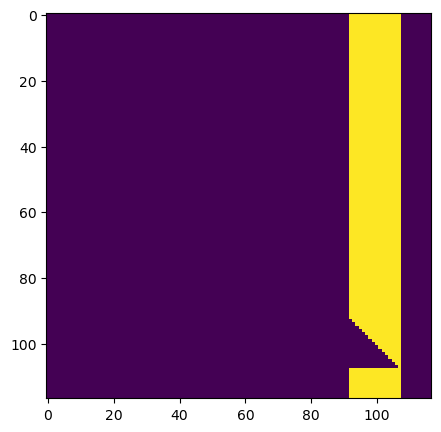

In [12]:
plt.figure(figsize=(5,5))
plt.imshow(mask)

In [13]:
import torch

class CDR3Dataset(torch.utils.data.Dataset):
    def __init__(self, V, CDR3, J, tgt, tokenizer, device):

        self.tokenizer = tokenizer
        self.V = V
        self.CDR3 = CDR3
        self.J = J
        self.labels = tgt
        self.device = device
        
        if len(tgt) == 1:
            self.V_max_length = len(V[0].split())
            self.CDR3_max_length = len(CDR3[0].split())
            self.J_max_length = len(J[0].split())
            self.max_length = len(tgt[0].split()) + 3
        else:
            length = 0
            V_length = 0
            CDR3_length = 0
            J_length = 0
            for i in range(len(tgt)):
                length = max(length, len(tgt[i].split())+3)
                V_length = max(V_length, len(V[i].split()))
                CDR3_length = max(CDR3_length, len(CDR3[i].split()))
                J_length = max(J_length, len(J[i].split()))

            self.max_length = length
            self.V_max_length = V_length +1 #[CLS]
            self.CDR3_max_length = CDR3_length
            self.J_max_length =  J_length + 2 #[SEP] and one [PAD]
            
           # print(self.CDR3_max_length)
 
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        tokenized = self.tokenizer(self.labels[idx], padding= 'max_length', max_length= self.max_length, return_tensors='pt', return_attention_mask=True)
        padded_tokenized_seq = tokenized['input_ids']
        pad_mask = ~tokenized['attention_mask'].to(torch.bool)
        
        
        v_idx = len(self.V[idx].replace(" ", "")) + 1 # Tokenizer adds [CLS] token at the beginning of the sequence
        cdr_idx = v_idx + len(self.CDR3[idx].replace(" ", ""))
        j_idx = cdr_idx + len(self.J[idx].replace(" ", "")) + 1 # Tokenizer adds [SEP] token at the end of the sequence
        
        V = padded_tokenized_seq[:, :v_idx]
        CDR3 = padded_tokenized_seq[:, v_idx:cdr_idx]
        J = padded_tokenized_seq[:, cdr_idx:]

        mask = self.subsequent_mask(V, CDR3, J)
        
        CDR3_label = torch.cat((CDR3, torch.full((1, self.CDR3_max_length - CDR3.shape[-1]), -100)), dim=-1)
        
        item = {'seq': padded_tokenized_seq.to(self.device),
                'V': V.to(self.device),
                'CDR3': CDR3.to(self.device),
                'J': J.to(self.device),
                'mask': mask.to(self.device),
                'pad_mask': pad_mask.to(self.device),
                'CDR3_label': CDR3_label.to(self.device)}
        
        return item
    
    def subsequent_mask(self, v, cdr3, j):

        cdr3_len = cdr3.shape[-1]
        v_len = v.shape[-1]
        j_len = j.shape[-1]

        v_block1 = np.zeros(shape=(v_len, v_len))
        v_block2 = np.zeros(shape=(cdr3_len, v_len))
        v_block3 = np.zeros(shape=(j_len, v_len))

        j_block1 = np.zeros(shape=(v_len, j_len))
        j_block2 = np.zeros(shape=(cdr3_len, j_len))
        j_block3 = np.zeros(shape=(j_len, j_len))

        cdr3_block1 = np.full(shape=(v_len, cdr3_len), fill_value=np.NINF)
        cdr3_block2 = np.triu(np.full((cdr3_len, cdr3_len), np.NINF), k = 0)
        cdr3_block3 = np.full(shape=(j_len, cdr3_len), fill_value=np.NINF)

        row1 = np.concatenate((v_block1, cdr3_block1, j_block1), axis=1)
        row2 = np.concatenate((v_block2, cdr3_block2, j_block2), axis=1)
        row3 = np.concatenate((v_block3, cdr3_block3, j_block3), axis=1)

        attention_mask = np.concatenate((row1, row2, row3), axis =0)

        return torch.from_numpy(attention_mask) != 0
        
    '''
    def __getitem__(self, idx):

        label = self.tokenizer(self.labels[idx], padding= 'max_length', max_length= self.max_length, return_tensors='pt')['input_ids']
        
        v_idx = len(self.V[idx].replace(" ", "")) + 1
        cdr_idx = v_idx + len(self.CDR3[idx].replace(" ", ""))
        j_idx = cdr_idx + len(self.J[idx].replace(" ", "")) +1
        
        
        V = torch.cat([label[:,:v_idx],
                       torch.full((1,self.V_max_length - v_idx), tokenizer.pad_token_id)],
                      dim=-1)

        CDR3 = torch.cat([label[:,v_idx: cdr_idx],
                          torch.full((1,self.CDR3_max_length -len(self.CDR3[idx].replace(" ", ""))), tokenizer.pad_token_id)],dim = -1)
        J = torch.cat([label[:,cdr_idx:j_idx],
                       torch.full((1,self.J_max_length-len(self.J[idx].replace(" ", ""))), tokenizer.pad_token_id)], dim=-1)# SEP
        V_mask = (V == self.tokenizer.pad_token_id).to(torch.bool)
        CDR3_mask = (CDR3 == self.tokenizer.pad_token_id).to(torch.bool)
        J_mask = (J == self.tokenizer.pad_token_id).to(torch.bool)
        pad = 0
        
        # V = label[:,: v_idx]
        # CDR3 = label[:,v_idx: cdr_idx]
        # J = label[:,cdr_idx:j_idx]
        
        # CDR3_label = torch.cat((CDR3, torch.full(size=(1,self.CDR3_max_length-CDR3.shape[1]), fill_value = -100)), dim=-1)
        # pad = self.max_length -len(self.labels[idx].replace(" ", ""))
        #  pad_mask = (label != self.tokenizer.pad_token_id).to(torch.boo
        CDR3_label = CDR3.clone().detach()
        #CDR3_label[CDR3_label!=self.tokenizer.pad_token_id] = 1
        CDR3_label[CDR3_label==self.tokenizer.pad_token_id] = -100
        
        
        mask = self.make_mask(V, CDR3, J, pad)
        
        item = {'V': V, 'CDR3': CDR3, 'J': J, 'V_mask': V_mask, 'CDR3_mask': CDR3_mask, 'J_mask': J_mask, 'mask':mask, 'CDR3_label': CDR3_label}

        return item
    
    def make_mask(self, V, CDR3, J, pad):
        return subsequent_mask(V, CDR3, J, pad)
    '''

In [14]:
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from tqdm import tqdm

In [15]:
def collate(list_of_samples):
        result = {}
        for sample in list_of_samples:
            for k, v in sample.items():
                if k not in result.keys():
                    if k == 'mask':
                        result[k] = [v]
                    else:
                        #print(v.shape)
                        result[k] = [v.squeeze()]
                else:
                    if k == 'mask':
                        result[k].append(v)
                    else:
                        #print(v.shape)
                        result[k].append(v.squeeze())
                    
        for k, v in result.items():
            if k != 'mask' and k != 'pad_mask' and k != 'CDR3_label':
                continue
            result[k] = torch.stack(v)
        result['mask'] = result['mask'].repeat(16,1,1)
        return result

In [16]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
train_set = CDR3Dataset(V_data[0:100], CDR3_data[0:100], J_data[0:100], tgt_data[0:100], tokenizer, device)
train_loader = DataLoader(train_set, shuffle=False, batch_size=8, collate_fn=collate)

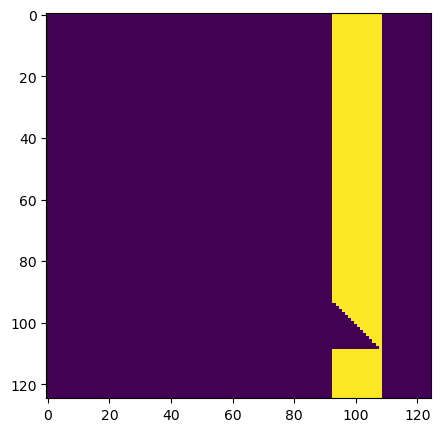

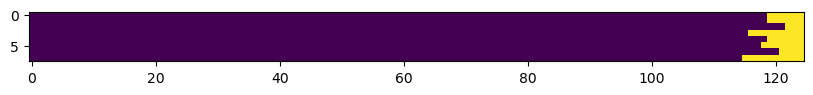

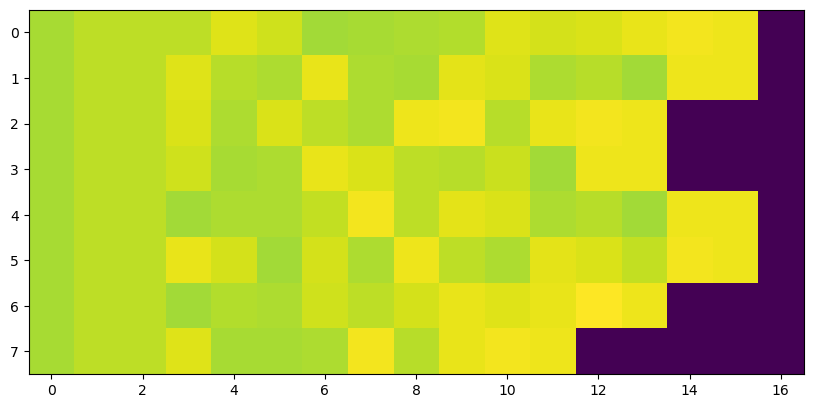

In [17]:
for batch in train_loader:
    for k, v in batch.items():
        if k =='mask':
            plt.figure(figsize=(5,5))
            plt.imshow(v[0])
        if k== 'pad_mask':
            plt.figure(figsize=(10,10))
            plt.imshow(v)
            
        if k=='CDR3_label':
            plt.figure(figsize=(10,10))
            plt.imshow(v)
    break

# Train loop

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = CustomprotBERT(base_model, train_set.CDR3_max_length).to(device)
EPOCHS = 10
optimizer = torch.optim.AdamW(model.parameters(), lr= 1e-6)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
model.train()

for epoch in range(EPOCHS):
    loop = tqdm(train_loader, leave=True, position=0, desc=f'epoch:{epoch+1}/{EPOCHS}')
    for idx, batch in enumerate(loop):
        #batch = { k: [] if type(v) == list else k: v.to(device) for k, v in batch.items()}
        
        logits = model(v = batch['V'],
                       cdr3 = batch['CDR3'],
                       j = batch['J'],
                       pad_mask = batch['pad_mask'],
                       mask = batch['mask'])

        
        loss = criterion(logits.transpose(1,2), batch['CDR3_label'])
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        perplexity = torch.exp(loss)
        loop.set_postfix(loss = loss.item(), PPL=perplexity.item())

In [ ]:
residues = torch.argmax(torch.softmax(logits, dim=-1), dim=-1)
print(tokenizer.decode(residues[0,:]))

label = batch['CDR3_label'][0,:]
label[label==-100] = 0

print(tokenizer.decode(label.squeeze(0)))

In [35]:
checkpoint = torch.load("../code/model_2/030823_customprotBERT_parallel_checkpoint.pth",  map_location="cpu")
#checkpoint = torch.load("../trained_models/CustomprotBERT_020823_checkpoint.pth",  map_location="cpu")
'''
model = CustomprotBERT(base_model, train_set.CDR3_max_length)
model.load_state_dict(checkpoint['model_state_dict'], strict=False)
'''
model = checkpoint['model']
model.eval()


CustomprotBERT(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30, 1024, padding_idx=0)
    (position_embeddings): Embedding(40000, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-29): 30 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (linear1): Linear(in_features=1024, out_features=4096, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear(in_features=4096, out_features=1024, bias=True)
        (norm1): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
        (norm2): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
        (dropout1): Dropout(p=0.0, inplace=False)
        (dropout2): Dropout(

In [36]:
train_set = CDR3Dataset(V_data[20000000:200000101], CDR3_data[20000000:200000101], J_data[20000000:200000101], tgt_data[20000000:200000101], tokenizer, device)
train_loader = DataLoader(train_set, shuffle=False, batch_size=100, collate_fn=collate)

In [52]:

with torch.no_grad():
    for batch in train_loader:
        idx = 67
        prob = []
        cdr3_pred =[torch.full((1,batch['CDR3'][idx].shape[-1]), 0).squeeze(0)]
        for i in tqdm(range(batch['CDR3'][idx].shape[-1]), leave=True, position=0):
            out = model(v = [batch['V'][idx]],
                       cdr3 = cdr3_pred,
                       j = [batch['J'][idx]])
            #cdr3_pred[0][i]= torch.multinomial(out.softmax(-1)[:,i], num_samples=1)
            cdr3_pred[0][i]= out.softmax(-1).argmax(-1)[:,i]
            prob.append(out.softmax(-1)[:,i,:])
        break

100%|██████████| 16/16 [00:29<00:00,  1.85s/it]


In [53]:
print(tokenizer.decode(cdr3_pred[0]))
for batch in train_loader:
    label = batch['CDR3_label'][idx]
    label[label==-100] = 0
    print(tokenizer.decode(label.squeeze(0)))
    break

A S S S L H Q Q Y F F F F F F F
A S S Q E A L R G D T D T Q Y F [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [ ]:
A S S S Y E Q Y F F F F F F

In [54]:
names = [tokenizer.decode(i) for i in range(0,30)]

<function matplotlib.pyplot.show(close=None, block=None)>

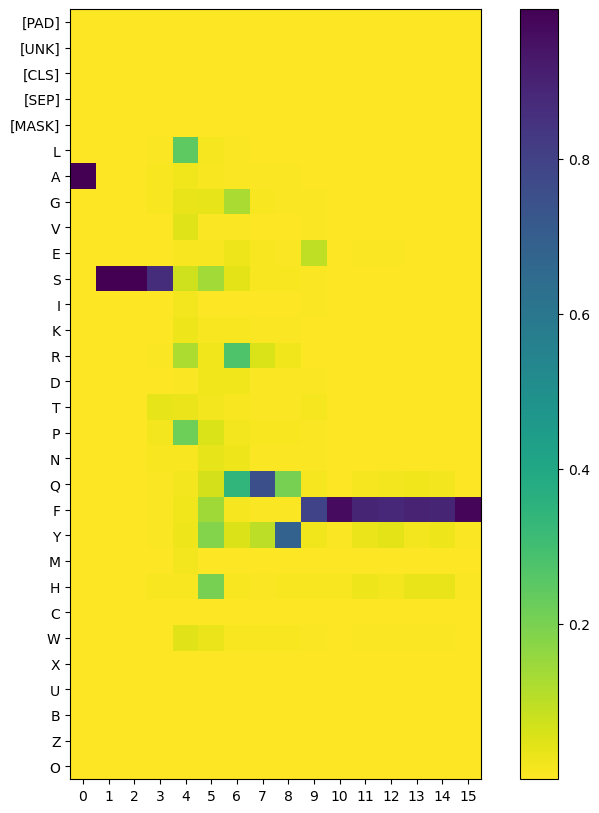

In [55]:
plt.figure(figsize=(10,10))
plt.imshow(torch.cat(prob, dim=0).t(), cmap='viridis_r')
plt.yticks(range(0,30), names)
plt.xticks(range(0,batch['CDR3'][idx].shape[-1]), range(0, batch['CDR3'][idx].shape[-1]))
plt.colorbar()
plt.show

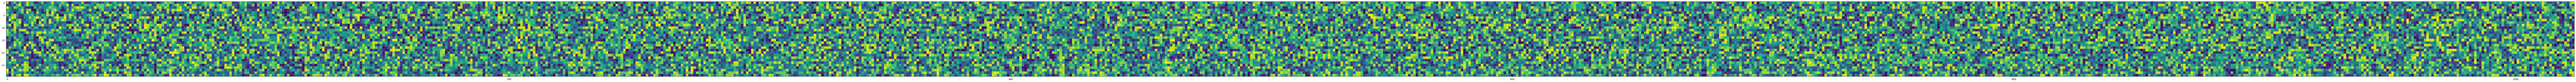

In [174]:
plt.figure(figsize=(200,200))
plt.imshow(model.fc.weight.detach().softmax(-1), cmap='viridis_r')

In [ ]:
print(torch.argmax(torch.cat(prob), dim =-1))

In [ ]:
torch.cat(prob)[0]

In [ ]:
tokenizer.decode(batch['V'][0])

# Testing the constructed model weight

Test if the Huggingface's model and Pytorch Transformer encoder return the same values at the last hidden state

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = CustomprotBERT(base_model).to(device)

In [ ]:
model.eval()
base_model.eval()
with torch.no_grad():
    loop = tqdm(train_loader, leave=True, position=0)
    for idx, batch in enumerate(loop):
        #print('input: {}'.format(batch['sequence'].shape))
        #print('mask: {}'.format(batch['mask'].shape))
                                
        batch = {k: v.to(device) for k, v in batch.items()}
        output = model(tokenized_sequence=batch['sequence'],pad_mask=batch['pad_mask'])#, mask = batch['mask'])

        '''
        output2 = base_model.embeddings(input_ids=batch['sequence'])
        output2 = base_model.encoder(output2, head_mask = batch['pad_mask'])
        '''
        #output2 = base_model.encoder.layer[0].attention.self(output2)
        #print(base_model.encoder.layer[0].attention.self.__dict__)

In [ ]:
output = torch.load("../code/model_2/model_out.pt", map_location=torch.device('cpu'))

In [ ]:
output2 = torch.load("../code/model_2/base_model_out.pt", map_location=torch.device('cpu'))

In [ ]:
b = torch.round(torch.abs(output2-output), decimals=3)
(b != 0).nonzero(as_tuple=True)

In [ ]:
output2[515]

In [ ]:
a = torch.where(torch.round(torch.abs(output2 -output), decimals=13) == 0, 1, 0)
'''
for i in range(514,516):
    plt.figure(figsize=(20,30))
    plt.imshow(a[i,:,:])
'''

In [ ]:
print(f'Number of elements, which are equal: {torch.count_nonzero(a)}')
print(f'Total amount of elements: {a.shape[0]*a.shape[1]*a.shape[2]}')
print(f'percentage {torch.count_nonzero(a)/(a.shape[0]*a.shape[1]*a.shape[2])*100}%')

In [ ]:
print(torch.allclose(output2, output, atol=1e-3))

In [ ]:
del base_model
del train_set, train_loader, device, model, batch
del output, output2

In [ ]:
print(V_data[0])
print(CDR3_data[0])

In [ ]:
v_idx = [len(i.replace(" ","")) -1 for i in V_data[0:10]] # Indeces of the last value of the v gene
cdr3_idx = [i + 17 for i in v_idx] 

In [ ]:
v_idx[0]

In [ ]:
V_data[0].replace(" ","")[91]